In [68]:
from sklearn.metrics.pairwise import polynomial_kernel, rbf_kernel
from scipy.linalg import svd
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import center_of_mass
from math import sqrt

In [69]:
(images, labels), (_, _) = mnist.load_data()
images.shape

flattened_images = images.reshape(images.shape[0], -1)

In [70]:
def get_distorted_values(source_x, source_y, radius, distortion, invert):
    if 1 - distortion * (radius ** 2) == 0:
        return source_x, source_y

    if not invert:
        return source_x / (1 - (distortion * (radius ** 2))), source_y / (1 - (distortion * (radius **2 )))
    
    return source_x * (1 - (distortion * (radius ** 2))), source_y * (1 - (distortion * (radius **2 )))
 


def fish(image, distortion_coefficient, invert=False):
    image_width, image_height = float(image.shape[0]), float(image.shape[1])
    new_image = np.zeros_like(image)

    for x in range(len(new_image)):
        for y in range(len(new_image[x])):

            # normalize x and y to be in interval of [-1, 1]
            x_normalized, y_normalized = float((2 * x - image_width) / image_width), float((2 * y - image_height) / image_height)

            radius = sqrt(x_normalized ** 2 + y_normalized ** 2)

            # new normalized pixel coordinates
            x_distorted, y_distorted = get_distorted_values(x_normalized, y_normalized, radius, distortion_coefficient, invert)

            # un-normalize
            x_nonnormalized, y_nonnormalized = int(((x_distorted + 1) * image_width) / 2), int(((y_distorted + 1) * image_height) / 2)

            # if new pixel is in bounds copy from source pixel to destination pixel
            if 0 <= x_nonnormalized and x_nonnormalized < image.shape[0] and 0 <= y_nonnormalized and y_nonnormalized < image.shape[1]:
                new_image[x][y] = image[x_nonnormalized][y_nonnormalized]


    return new_image.astype(np.uint8)

In [71]:
def perform_fisheye_transform(data, distortion, invert=False):
    new_images = []
    for i in range(data.shape[0]):
        image = data[i, :, :].reshape((28, 28))
        new_images.append(fish(image, distortion, invert))
    return np.array(new_images)

In [73]:
fisheye_0_5 = perform_fisheye_transform(images, 0.5)
flattened_fisheye_0_5 = fisheye_0_5.reshape(fisheye_0_5.shape[0], -1)

fisheye_1 = perform_fisheye_transform(images, 1)
flattened_fisheye_1 = fisheye_1.reshape(fisheye_1.shape[0], -1)

fisheye_2_5 = perform_fisheye_transform(images, 2.5)
flattened_fisheye_2_5 = fisheye_2_5.reshape(fisheye_2_5.shape[0], -1)

fisheye_5 = perform_fisheye_transform(images, 5)
flattened_fisheye_5 = fisheye_5.reshape(fisheye_5.shape[0], -1)

In [74]:
U_orig, E_orig, V_t_orig = np.linalg.svd(flattened_images, full_matrices=False)

U_fish_0_5, E_fish_0_5, V_t_fish_0_5 = np.linalg.svd(flattened_fisheye_0_5, full_matrices=False)
U_fish_1, E_fish_1, V_t_fish_1 = np.linalg.svd(flattened_fisheye_1, full_matrices=False)
U_fish_2_5, E_fish_2_5, V_t_fish_2_5 = np.linalg.svd(flattened_fisheye_2_5, full_matrices=False)
U_fish_5, E_fish_5, V_t_fish_5 = np.linalg.svd(flattened_fisheye_5, full_matrices=False)

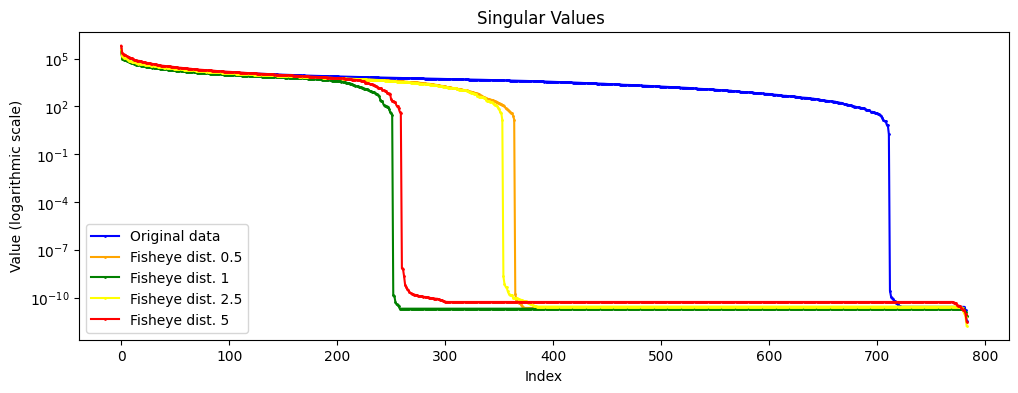

In [75]:
plt.figure(figsize=(12, 4))
plt.plot(E_orig, marker='o', color="blue", markersize=1, label="Original data")
plt.plot(E_fish_0_5, marker='o', color='orange', markersize=1, label="Fisheye dist. 0.5")
plt.plot(E_fish_1, marker='o', color='green', markersize=1, label="Fisheye dist. 1")
plt.plot(E_fish_2_5, marker='o', color='yellow', markersize=1, label="Fisheye dist. 2.5")
plt.plot(E_fish_5, marker='o', color='red', markersize=1, label="Fisheye dist. 5")
plt.title("Singular Values ")
plt.xlabel("Index")
plt.ylabel("Value (logarithmic scale)")
plt.yscale("log")
plt.legend()
plt.show()


Text(0.5, 1.0, 'Fisheye dist 5')

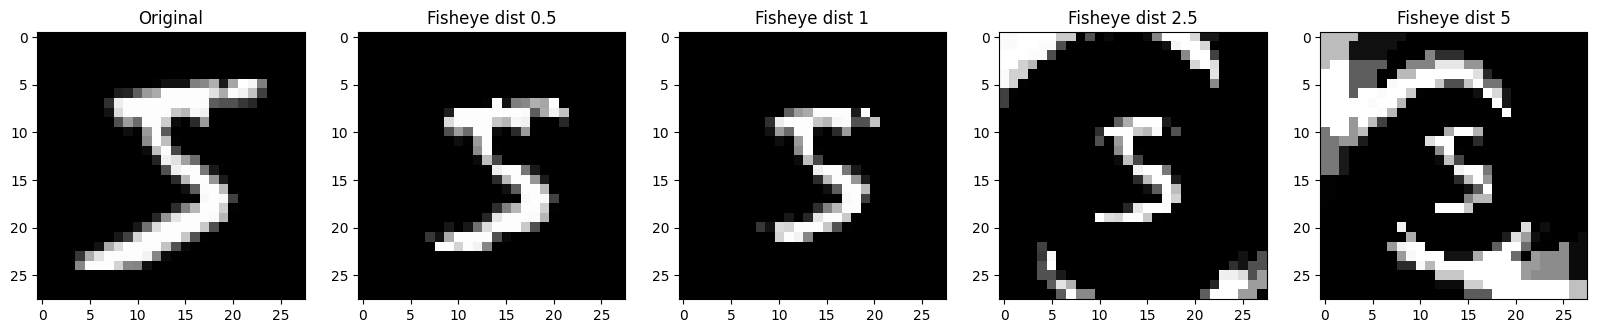

In [76]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 5, 1)
plt.imshow(images[0], cmap='gray')
plt.title('Original')

plt.subplot(1, 5, 2)
plt.imshow(fisheye_0_5[0], cmap='gray')
plt.title('Fisheye dist 0.5')

plt.subplot(1, 5, 3)
plt.imshow(fisheye_1[0], cmap='gray')
plt.title('Fisheye dist 1')

plt.subplot(1, 5, 4)
plt.imshow(fisheye_2_5[0], cmap='gray')
plt.title('Fisheye dist 2.5')

plt.subplot(1, 5, 5)
plt.imshow(fisheye_5[0], cmap='gray')
plt.title('Fisheye dist 5')

In [77]:

U_fish_0_5, E_fish_0_5, V_t_fish_0_5 = np.linalg.svd(flattened_fisheye_0_5, full_matrices=False)
U_fish_1, E_fish_1, V_t_fish_1 = np.linalg.svd(flattened_fisheye_1, full_matrices=False)
U_fish_1, E_fish_1, V_t_fish_2_5 = np.linalg.svd(flattened_fisheye_2_5, full_matrices=False)
U_fish_5, E_fish_5, V_t_fish_5 = np.linalg.svd(flattened_fisheye_5, full_matrices=False)

In [78]:
# reconstruct using k singular values
def reconstruct(data, k_values, distortion=0):
    if distortion != 0:
        data = perform_fisheye_transform(data, distortion)
        
    data_flat = data.reshape(data.shape[0], -1)
    U, E, V_t = np.linalg.svd(data_flat, full_matrices=False)
    U_k = U[:, :k_values]
    E_k = np.diag(E[:k_values])
    V_k = V_t[:k_values, :]

    k_reduced = np.dot(U_k, np.dot(E_k, V_k)).reshape(data.shape[0], 28, 28)
    
    if distortion != 0:
        k_reduced = perform_fisheye_transform(k_reduced, -distortion, True)
    return k_reduced


In [79]:
# Reconstruct
def reconstruct_plot(k):
    original_rec = reconstruct(images, k_values=k, distortion=0)
    fish_05_rec = reconstruct(images, k_values=k, distortion=0.5)
    fish_1_rec = reconstruct(images, k_values=k, distortion=1)
    fish_2_5_rec = reconstruct(images, k_values=k, distortion=2.5)
    fish_5_rec = reconstruct(images, k_values=k, distortion=5)

    fig = plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 5, 1)
    plt.imshow(original_rec[0], cmap='gray')
    plt.title('Original')

    plt.subplot(1, 5, 2)
    plt.imshow(fish_05_rec[0], cmap='gray')
    plt.title('Fisheye dist 0.5')

    plt.subplot(1, 5, 3)
    plt.imshow(fish_1_rec[0], cmap='gray')
    plt.title('inv Fisheye dist 1')

    plt.subplot(1, 5, 4)
    plt.imshow(fish_2_5_rec[0], cmap='gray')
    plt.title('inv Fisheye dist 2.5')

    plt.subplot(1, 5, 5)
    plt.imshow(fish_5_rec[0], cmap='gray')
    plt.title('inv Fisheye dist 5')

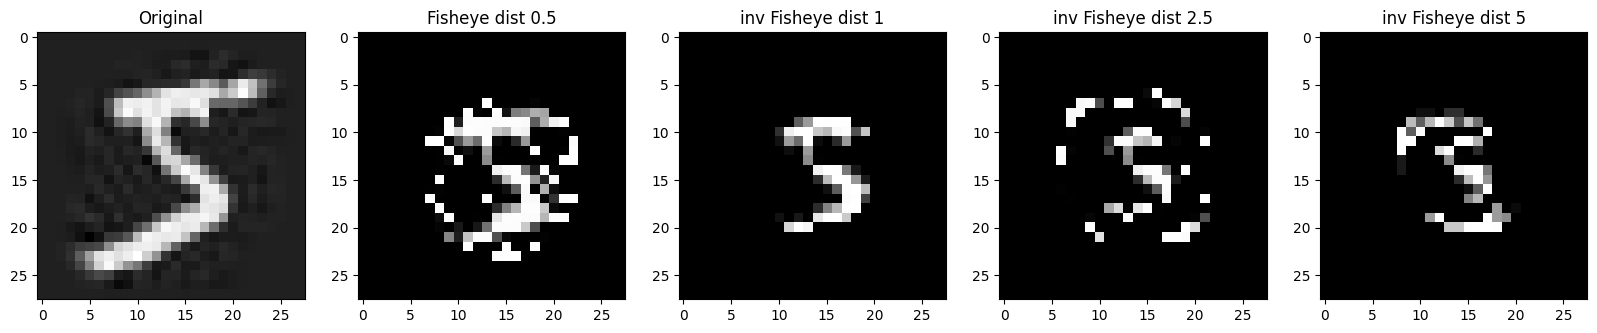

In [80]:
reconstruct_plot(250)

In [82]:
# Initialize empty arrays for each digit class
zeros_images = []
ones_images = []
twos_images = []
threes_images = []
fours_images = []
fives_images = []
sixes_images = []
sevens_images = []
eights_images = []
nines_images = []

for image, label in zip(images, labels):
    if label == 0:
        zeros_images.append(image)
    elif label == 1:
        ones_images.append(image)
    elif label == 2:
        twos_images.append(image)
    elif label == 3:
        threes_images.append(image)
    elif label == 4:
        fours_images.append(image)
    elif label == 5:
        fives_images.append(image)
    elif label == 6:
        sixes_images.append(image)
    elif label == 7:
        sevens_images.append(image)
    elif label == 8:
        eights_images.append(image)
    elif label == 9:
        nines_images.append(image)

zeros_images = np.array(zeros_images)
ones_images = np.array(ones_images)
twos_images = np.array(twos_images)
threes_images = np.array(threes_images)
fours_images = np.array(fours_images)
fives_images = np.array(fives_images)
sixes_images = np.array(sixes_images)
sevens_images = np.array(sevens_images)
eights_images = np.array(eights_images)
nines_images = np.array(nines_images)


In [135]:
def plot_singular_values_by_digit_2(data: [], digit, distortions=[0, 1, 2.5, 5]):
    fisheye_1 = perform_fisheye_transform(data, distortions[1])
    fisheye_2_5 = perform_fisheye_transform(data, distortions[2])
    fisheye_5 = perform_fisheye_transform(data, distortions[3])

    U_orig, E_orig, V_t_orig = np.linalg.svd(data.reshape(data.shape[0], -1), full_matrices=False)
    U_fish_0_5, E_fish_0_5, V_t_fish_0_5 = np.linalg.svd(fisheye_1.reshape(fisheye_1.shape[0], -1), full_matrices=False)
    U_fish_1, E_fish_1, V_t_fish_1 = np.linalg.svd(fisheye_2_5.reshape(fisheye_2_5.shape[0], -1), full_matrices=False)
    U_fish_5, E_fish_5, V_t_fish_5 = np.linalg.svd(fisheye_5.reshape(fisheye_5.shape[0], -1), full_matrices=False)

    plt.figure(figsize=(12, 4))
    plt.plot(E_orig, marker='o', color="blue", markersize=1, label="Original data")
    plt.plot(E_fish_1, marker='o', color='green', markersize=1, label=f"Fisheye dist. {distortions[1]}")
    plt.plot(E_fish_2_5, marker='o', color='red', markersize=1, label=f"Fisheye dist. {distortions[2]}")
    plt.plot(E_fish_5, marker='o', color='yellow', markersize=1, label=f"Fisheye dist. {distortions[3]}")

    plt.title(f"Singular Values - Digit {digit} - {data.shape[0]} Samples")
    plt.xlabel("Index")
    plt.ylabel("Value (logarithmic scale)")
    plt.yscale("log")
    plt.legend()
    plt.show()

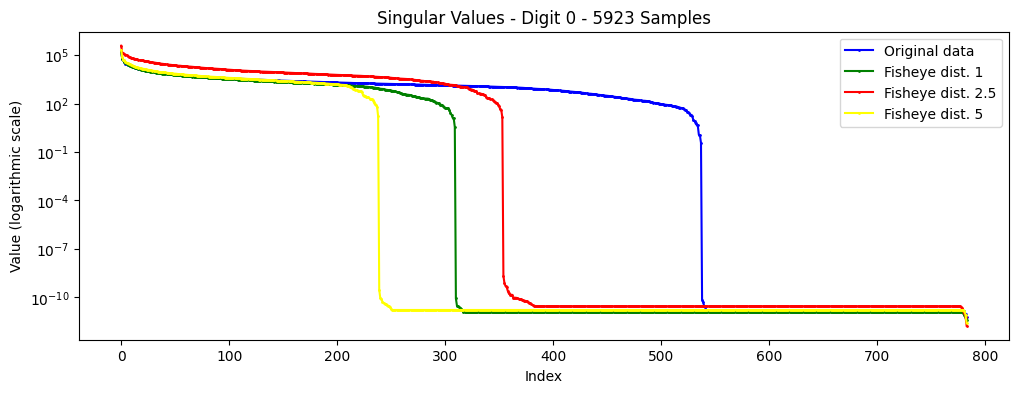

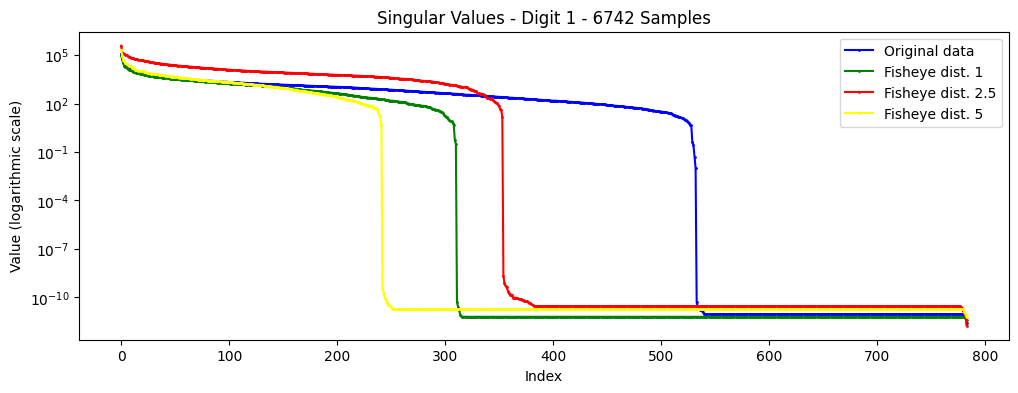

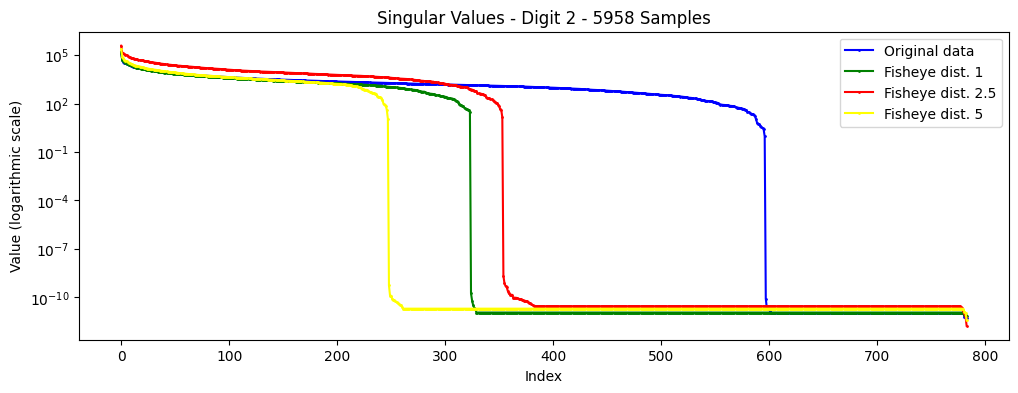

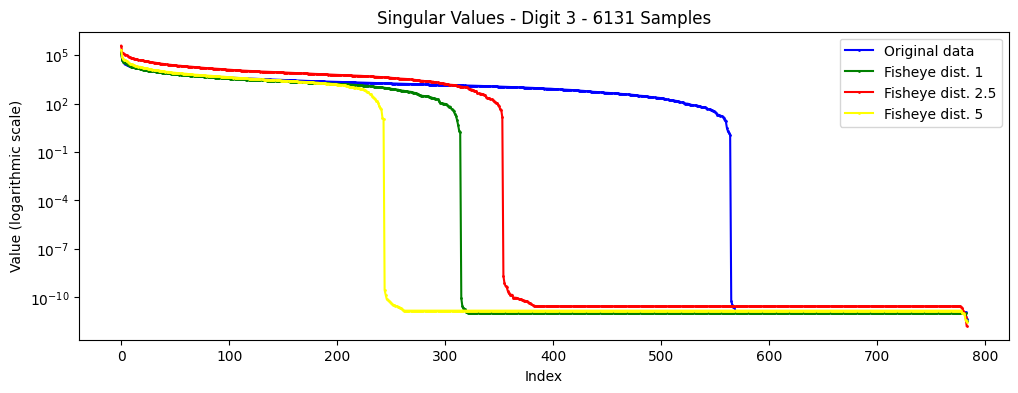

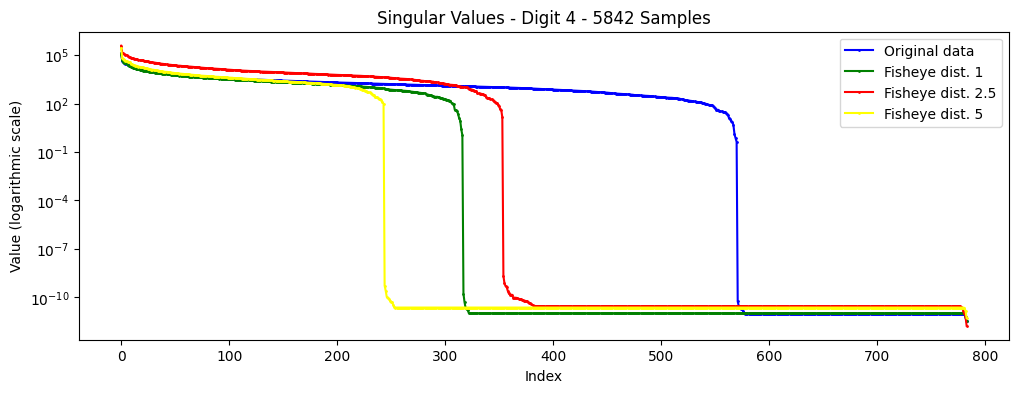

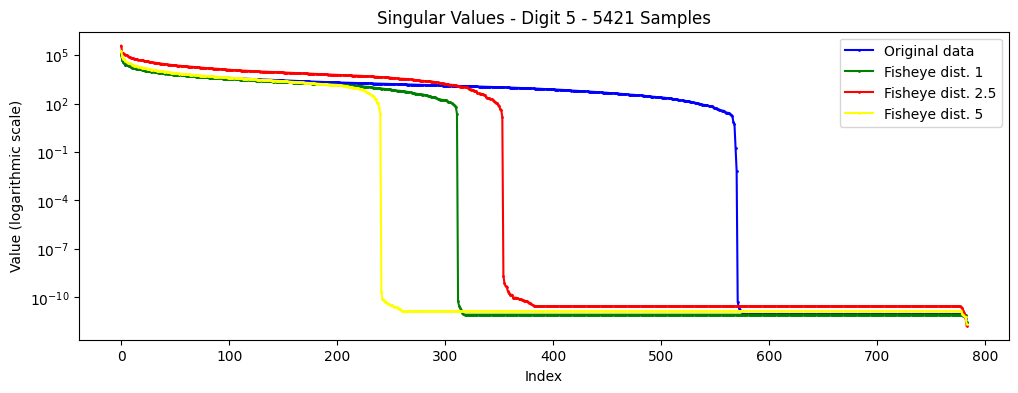

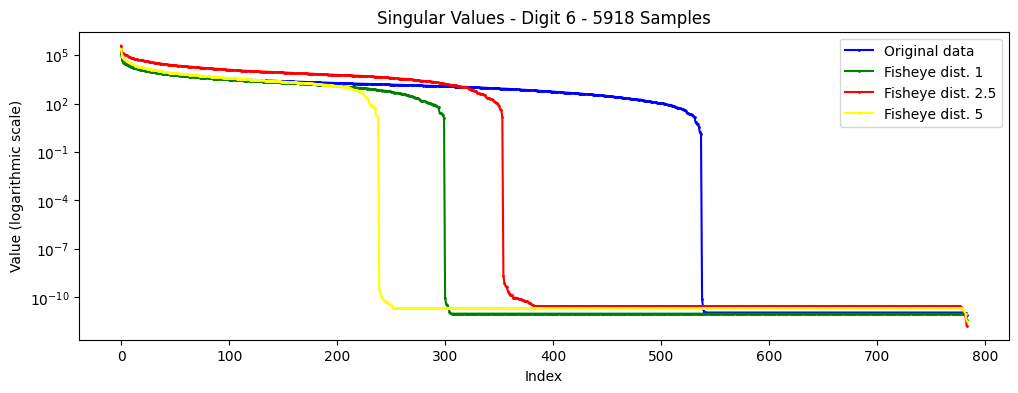

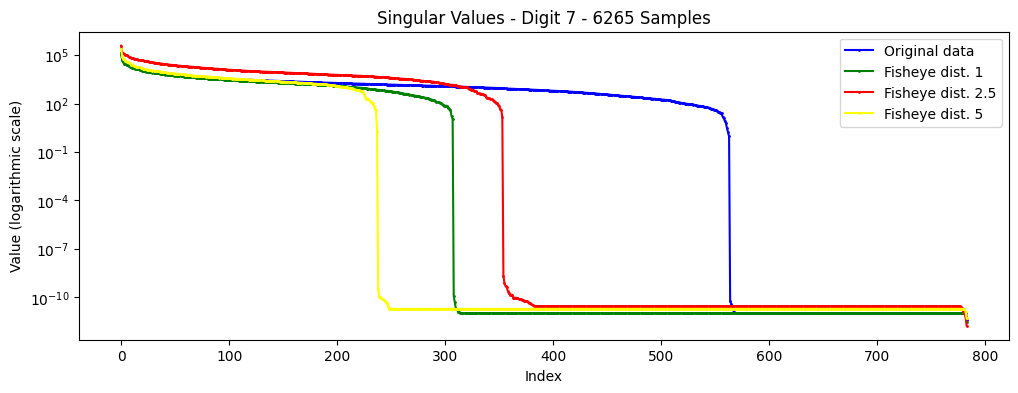

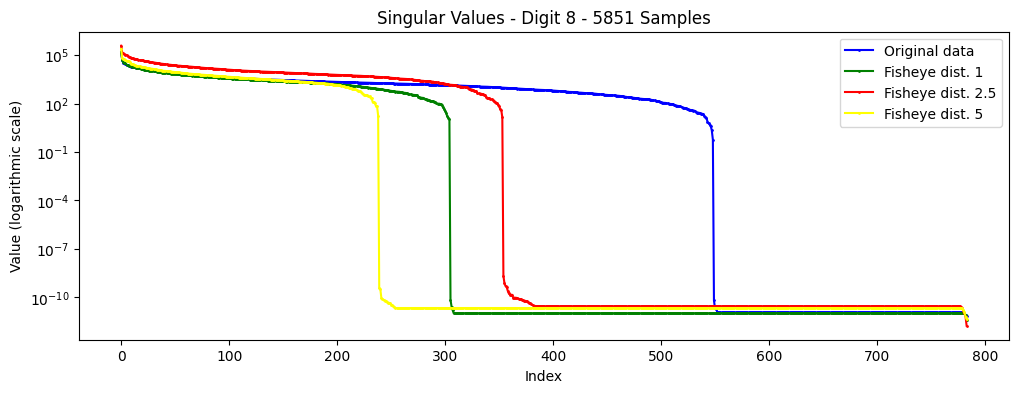

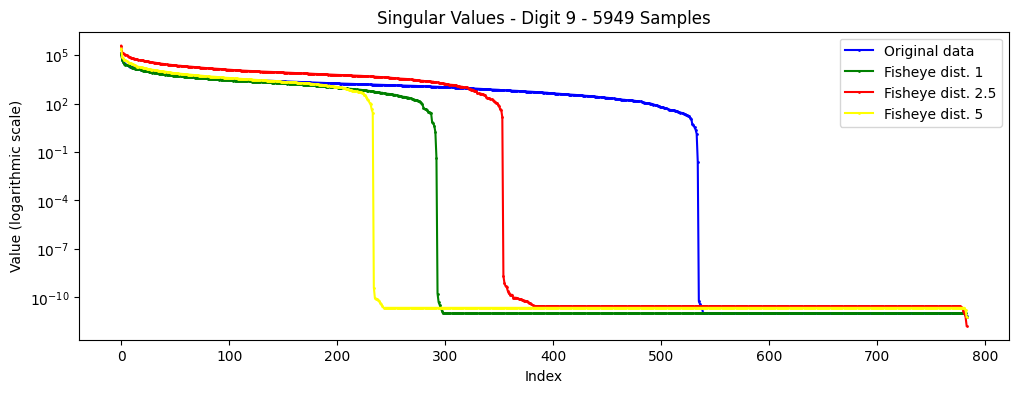

In [136]:
plot_singular_values_by_digit_2(zeros_images, 0)
plot_singular_values_by_digit_2(ones_images, 1)
plot_singular_values_by_digit_2(twos_images, 2)
plot_singular_values_by_digit_2(threes_images, 3)
plot_singular_values_by_digit_2(fours_images, 4)
plot_singular_values_by_digit_2(fives_images, 5)
plot_singular_values_by_digit_2(sixes_images, 6)
plot_singular_values_by_digit_2(sevens_images, 7)
plot_singular_values_by_digit_2(eights_images, 8)
plot_singular_values_by_digit_2(nines_images, 9)

In [137]:
def get_dropoff_index(singular_values):
    log_points = np.log10(singular_values)

    diff_log_points = np.diff(log_points)

    max_dropoff_index = np.argmax(diff_log_points)
    return max_dropoff_index

In [138]:
# using the function above, i want to compare the dropoff indices for each digit with original data and fisheye dist 1, fish dist 2.5, and fish dist 5. plot each of these in a bar chart for each digit on the same plot.
def plot_dropoff_indices(data: [], digit, distortions=[0, 1, 2.5, 5]):
    fisheye_1 = perform_fisheye_transform(data, distortions[1])
    flattened_fisheye_1 = fisheye_1.reshape(fisheye_1.shape[0], -1)

    fisheye_2_5 = perform_fisheye_transform(data, distortions[2])
    flattened_fisheye_2_5 = fisheye_2_5.reshape(fisheye_2_5.shape[0], -1)

    fisheye_5 = perform_fisheye_transform(data, distortions[2])
    flattened_fisheye_5 = fisheye_5.reshape(fisheye_5.shape[0], -1)

    U_orig, E_orig, V_t_orig = np.linalg.svd(data.reshape(data.shape[0], -1), full_matrices=False)
    U_fish_0_5, E_fish_0_5, V_t_fish_0_5 = np.linalg.svd(flattened_fisheye_0_5, full_matrices=False)
    U_fish_1, E_fish_1, V_t_fish_1 = np.linalg.svd(flattened_fisheye_1, full_matrices=False)
    U_fish_5, E_fish_5, V_t_fish_5 = np.linalg.svd(flattened_fisheye_5, full_matrices=False)

    dropoff_index_orig = get_dropoff_index(E_orig)
    dropoff_index_fish_1 = get_dropoff_index(E_fish_1)
    dropoff_index_fish_2_5 = get_dropoff_index(E_fish_2_5)
    dropoff_index_fish_5 = get_dropoff_index(E_fish_5)

    plt.figure(figsize=(12, 4))
    bars = plt.bar(x=['Original', 'Fisheye dist. 1', 'Fisheye dist. 2.5', 'Fisheye dist. 5'],
               height=[dropoff_index_orig, dropoff_index_fish_1, dropoff_index_fish_2_5, dropoff_index_fish_5])

    # Display values above each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

    # Title and labels
    plt.title(f"Dropoff Index - Digit {digit} - {data.shape[0]} Samples")
    plt.xlabel("Data")
    plt.ylabel("Index")

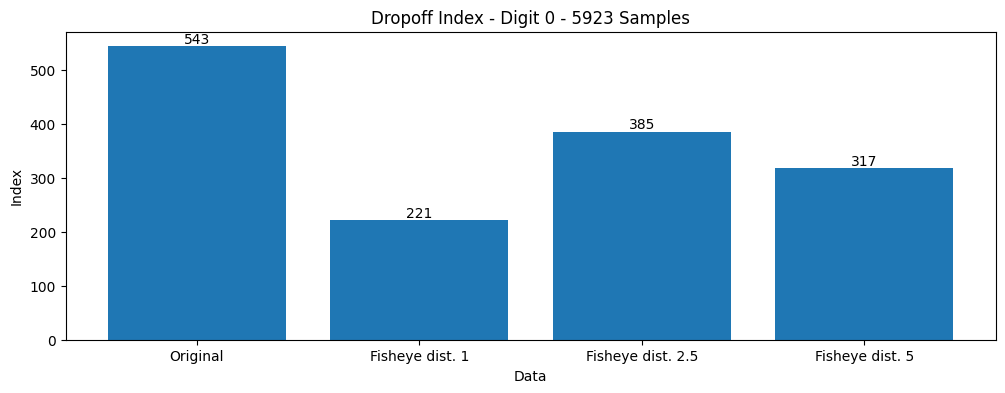

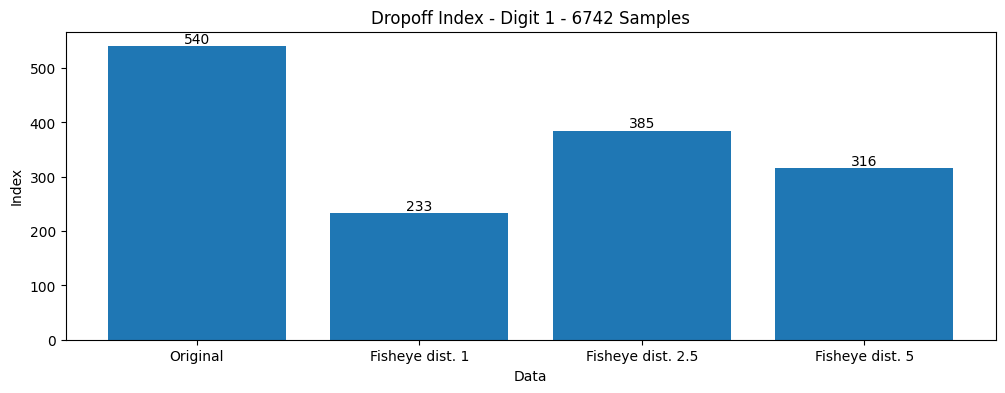

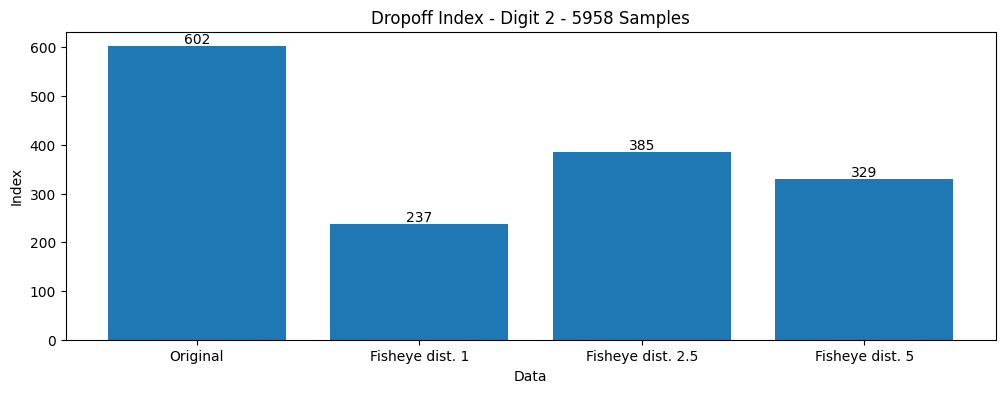

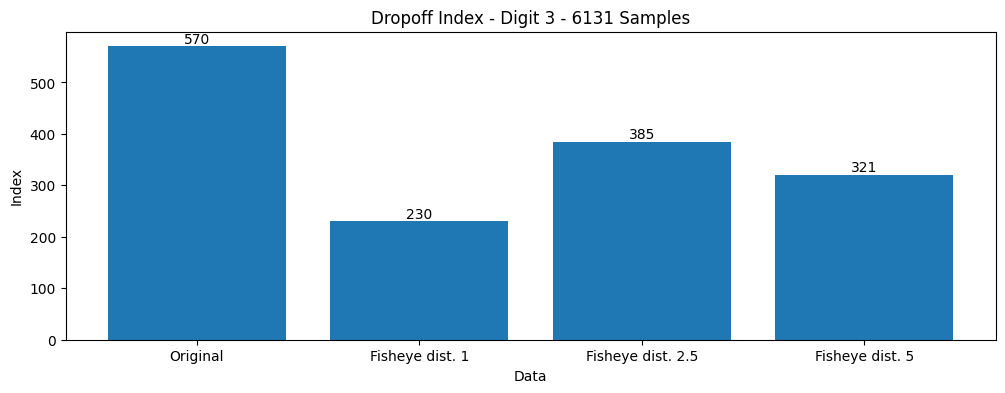

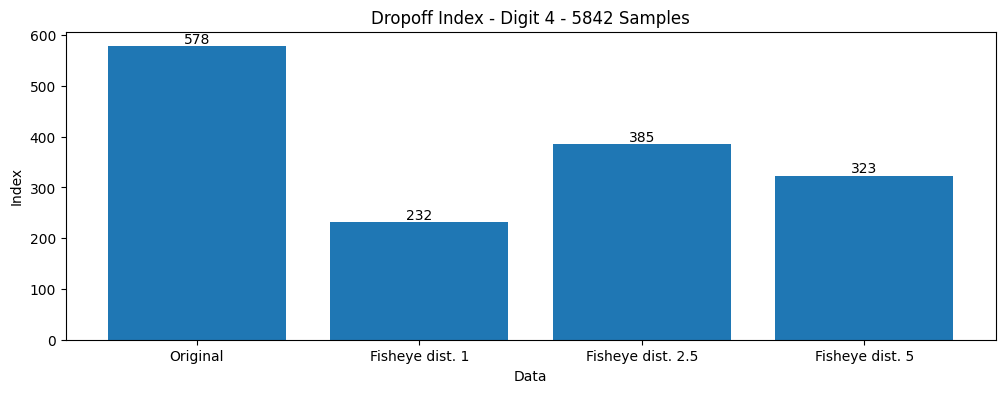

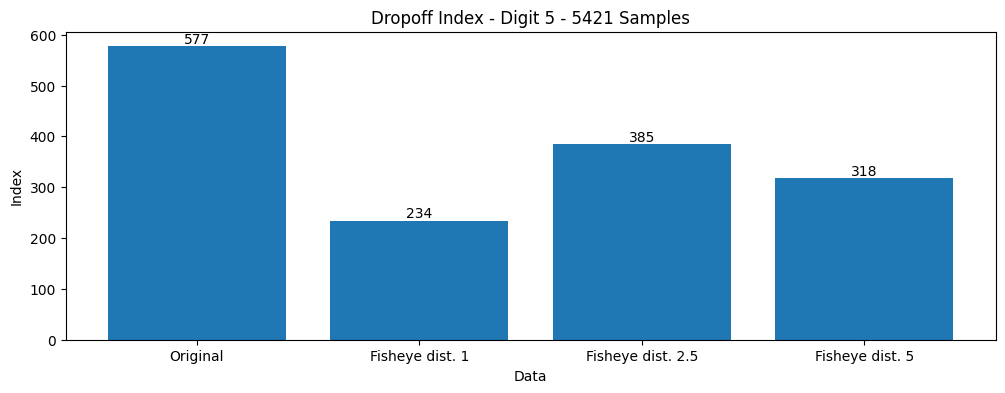

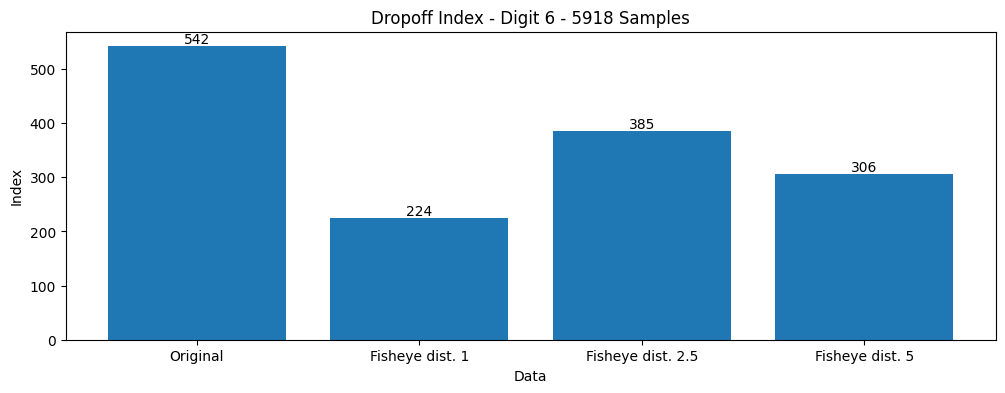

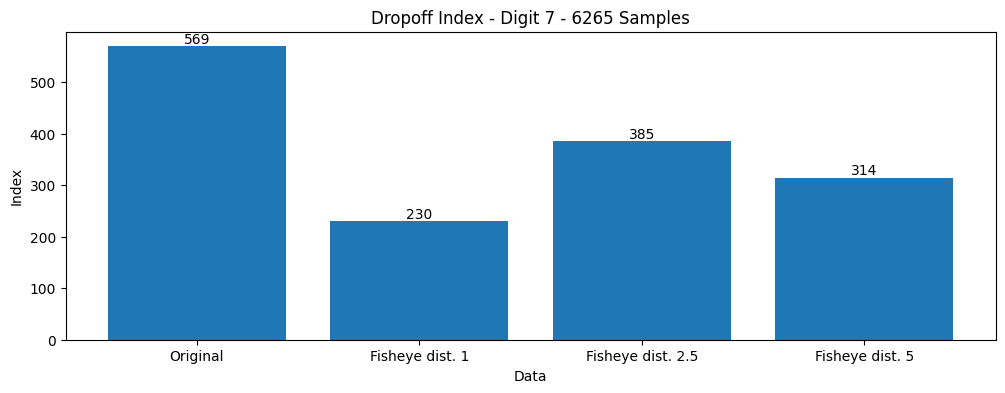

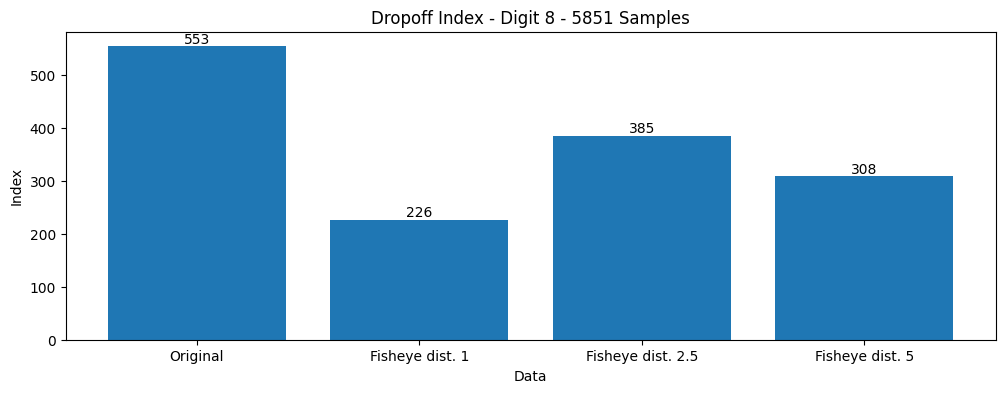

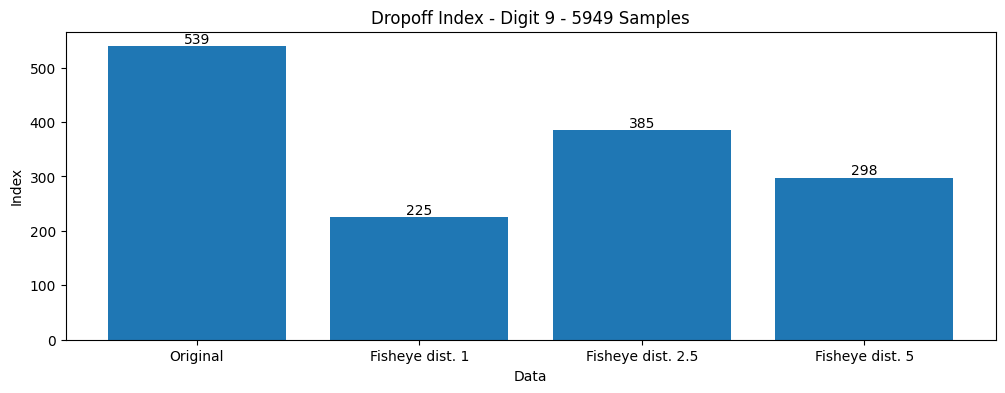

In [139]:
plot_dropoff_indices(zeros_images,  0)
plot_dropoff_indices(ones_images,   1)
plot_dropoff_indices(twos_images,   2)
plot_dropoff_indices(threes_images, 3)
plot_dropoff_indices(fours_images,  4)
plot_dropoff_indices(fives_images,  5)
plot_dropoff_indices(sixes_images,  6)
plot_dropoff_indices(sevens_images, 7)
plot_dropoff_indices(eights_images, 8)
plot_dropoff_indices(nines_images,  9)